In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Change to your data directory
import os
os.chdir('/content/drive/MyDrive/Saarland')

Mounted at /content/drive


In [3]:
# Load data
cols = ['date_name', 'local_team', 'visitor_team', 'local_result', 'visitor_result']
df = pd.read_csv('argentina_league_scores.csv', usecols=cols)

print(f"Total matches: {len(df)}")
print(f"\nSample of tournaments/seasons:")
print(df['date_name'].value_counts().head(20))
df.head()

Total matches: 32854

Sample of tournaments/seasons:
date_name
Torneo Nacional 1982 - Torneo Nacional         238
Torneo Nacional 1983 - Torneo Nacional         186
Metropolitano 1967 - Grupo A                   110
Metropolitano 1969 - Grupo B                   110
Metropolitano 1976 - Grupo A                   110
Metropolitano 1976 - Grupo B                   110
Metropolitano 1968 - Grupo B                   110
Metropolitano 1967 - Grupo B                   110
Metropolitano 1969 - Grupo A                   110
Metropolitano 1968 - Grupo A                   109
Nacional 1973 - Grupo B                        105
Nacional 1973 - Grupo A                        105
Nacional 1967 - Grupo Reclasificatorio          90
Metropolitano 1979 - Grupo A                    90
Metropolitano 1968 - Grupo Reclasificatorio     90
Nacional 1970 - Grupo B                         90
Nacional 1970 - Grupo A                         90
Metropolitano 1979 - Grupo B                    90
Nacional 1971 - Gru

,date_name,local_team,local_result,visitor_result,visitor_team
0,Nacional 1976 - Grupo C,All Boys,2,0,Aldosivi
1,Nacional 1976 - Grupo C,Aldosivi,4,0,All Boys
2,Superliga 2019/20 - Fecha 2,Aldosivi,0,0,Argentinos
3,Superliga 2018/19 - Fecha 15,Argentinos,1,2,Aldosivi
4,Torneo 2016 - Fecha 2,Aldosivi,3,2,Argentinos


In [4]:
# Extract year from date_name
def extract_year(date_name):
    """Extract starting year from season name"""
    import re
    match = re.search(r'(\d{4})', str(date_name))
    if match:
        return int(match.group(1))
    return None

df['Year'] = df['date_name'].apply(extract_year)

# Rename for consistency
df = df.rename(columns={
    'local_team': 'HomeTeam',
    'visitor_team': 'AwayTeam',
    'local_result': 'HomeScore',
    'visitor_result': 'AwayScore'
})

# Drop rows with missing scores or years
df = df.dropna(subset=['HomeScore', 'AwayScore', 'Year'])
df['HomeScore'] = df['HomeScore'].astype(int)
df['AwayScore'] = df['AwayScore'].astype(int)
df['Year'] = df['Year'].astype(int)

print(f"Valid matches after cleaning: {len(df)}")
print(f"Year range: {df['Year'].min()} - {df['Year'].max()}")
print(f"\nMatches per year:")
print(df.groupby('Year').size().sort_index())

Valid matches after cleaning: 32854
Year range: 1931 - 2021

Matches per year:
Year
1931    305
1932    307
1933    306
1934    211
1935    306
       ... 
2016    692
2017    378
2018    325
2019    276
2021     54
Length: 90, dtype: int64


In [5]:
# Extract tournament type and create a season identifier
def get_tournament_type(date_name):
    """Categorize tournament types"""
    if 'Superliga' in date_name:
        return 'Superliga'
    elif 'Liga' in date_name:
        return 'Liga'
    elif 'Metropolitano' in date_name:
        return 'Metropolitano'
    elif 'Nacional' in date_name:
        return 'Nacional'
    elif 'Apertura' in date_name:
        return 'Apertura'
    elif 'Clausura' in date_name:
        return 'Clausura'
    elif 'Inicial' in date_name:
        return 'Inicial'
    elif 'Final' in date_name:
        return 'Final'
    elif 'Torneo' in date_name:
        return 'Torneo'
    elif 'Campeonato' in date_name:
        return 'Campeonato'
    else:
        return 'Other'

df['TournamentType'] = df['date_name'].apply(get_tournament_type)

# Create unique season identifier
df['Season'] = df['date_name'].str.split(' - ').str[0]

print("Tournament types:")
print(df['TournamentType'].value_counts())
print(f"\nTotal unique seasons: {df['Season'].nunique()}")

Tournament types:
TournamentType
Campeonato       12365
Metropolitano     5779
Clausura          4260
Nacional          4077
Apertura          3994
Superliga          979
Torneo             431
Final              385
Inicial            380
Other              150
Liga                54
Name: count, dtype: int64

Total unique seasons: 136


## Calculate Per-Team Points Per Game (Peko's Method)

Following Getty et al. (2018), we calculate PPG for each team, then use random splits to compute R*.

In [6]:

def get_team_games(df, team):
    """Get all games for a specific team"""
    home_games = df[df['HomeTeam'] == team].copy()
    home_games['is_home'] = True
    home_games['team_score'] = home_games['HomeScore']
    home_games['opp_score'] = home_games['AwayScore']
    home_games['opponent'] = home_games['AwayTeam']

    away_games = df[df['AwayTeam'] == team].copy()
    away_games['is_home'] = False
    away_games['team_score'] = away_games['AwayScore']
    away_games['opp_score'] = away_games['HomeScore']
    away_games['opponent'] = away_games['HomeTeam']

    team_games = pd.concat([home_games, away_games])

    # Calculate points (3 for win, 1 for draw, 0 for loss)
    team_games['points'] = 0
    team_games.loc[team_games['team_score'] > team_games['opp_score'], 'points'] = 3
    team_games.loc[team_games['team_score'] == team_games['opp_score'], 'points'] = 1

    return team_games

def calculate_r_peko_method(df_subset, n_folds=100):
    """
    Calculate R* using Peko's method:
    1. For each team, randomly split games K times
    2. Calculate PPG for each split
    3. Pool all (x,y) pairs across teams and splits
    4. Transform to S,T coordinates
    5. Calculate R = 1 - var(T)/var(S)
    """
    if len(df_subset) < 20:
        return np.nan

    teams = sorted(set(df_subset['HomeTeam']).union(set(df_subset['AwayTeam'])))

    # Collect all (x,y) pairs
    XY_pairs = []

    for team in teams:
        team_games = get_team_games(df_subset, team)
        n_games = len(team_games)

        # Skip teams with too few games
        if n_games < 4:
            continue

        # Perform K random splits for this team
        for k in range(n_folds):
            # Randomly assign games to fold A or B
            fold = np.random.randint(0, 2, n_games)

            games_a = team_games.iloc[fold == 0]
            games_b = team_games.iloc[fold == 1]

            # Calculate PPG (points per game)
            if len(games_a) > 0 and len(games_b) > 0:
                x = games_a['points'].sum() / len(games_a)
                y = games_b['points'].sum() / len(games_b)
                XY_pairs.append((x, y))

    if len(XY_pairs) < 3:
        return np.nan

    # Convert to arrays
    X = np.array([x for x, y in XY_pairs])
    Y = np.array([y for x, y in XY_pairs])

    # Transform to S, T coordinates
    S = (X + Y) / np.sqrt(2)
    T = (Y - X) / np.sqrt(2)

    # Calculate variances (using ddof=0)
    var_S = np.var(S, ddof=0)
    var_T = np.var(T, ddof=0)

    # Calculate R
    if var_S > 1e-12:
        R = 1 - var_T / var_S
    else:
        R = np.nan

    return R

## Calculate R by Season

In [7]:
results = []

# Filter to only Apertura and Clausura tournaments
df_filtered = df[df['TournamentType'].isin(['Apertura', 'Clausura'])]

print(f"Total matches in Apertura/Clausura: {len(df_filtered)}")
print(f"Apertura seasons: {(df_filtered['TournamentType'] == 'Apertura').sum()}")
print(f"Clausura seasons: {(df_filtered['TournamentType'] == 'Clausura').sum()}")
print()

for season in sorted(df_filtered['Season'].unique()):
    season_data = df_filtered[df_filtered['Season'] == season]

    n_teams = len(set(season_data['HomeTeam']).union(set(season_data['AwayTeam'])))
    n_games = len(season_data)
    year = season_data['Year'].iloc[0]
    tournament_type = season_data['TournamentType'].iloc[0]

    if n_games >= 20:
        r_val = calculate_r_peko_method(season_data, n_folds=100)

        results.append({
            'Season': season,
            'Year': year,
            'TournamentType': tournament_type,
            'N_Teams': n_teams,
            'N_Games': n_games,
            'R_Value': r_val
        })

results_df = pd.DataFrame(results)
results_df = results_df.round({'R_Value': 2})
print(f"\nTotal Apertura/Clausura seasons analyzed: {len(results_df)}")
results_df.head(20)

Total matches in Apertura/Clausura: 8254
Apertura seasons: 3994
Clausura seasons: 4260


Total Apertura/Clausura seasons analyzed: 43


,Season,Year,TournamentType,N_Teams,N_Games,R_Value
0,Torneo Apertura 1991,1991,Apertura,20,190,0.33
1,Torneo Apertura 1992,1992,Apertura,20,190,0.19
2,Torneo Apertura 1993,1993,Apertura,20,190,-0.08
3,Torneo Apertura 1994,1994,Apertura,20,190,0.45
4,Torneo Apertura 1995,1995,Apertura,20,190,0.51
5,Torneo Apertura 1996,1996,Apertura,20,190,0.49
6,Torneo Apertura 1997,1997,Apertura,20,190,0.64
7,Torneo Apertura 1998,1998,Apertura,20,190,0.32
8,Torneo Apertura 1999,1999,Apertura,20,190,0.69
9,Torneo Apertura 2000,2000,Apertura,20,190,0.62


## Summary Statistics (Apertura & Clausura Only)

In [8]:
summary = results_df.groupby('TournamentType').agg({
    'R_Value': ['mean', 'std', 'min', 'max', 'count'],
    'Year': ['min', 'max']
}).round(3)

summary.columns = ['Mean_R', 'Std_R', 'Min_R', 'Max_R', 'N_Seasons', 'First_Year', 'Last_Year']
summary = summary.sort_values('Mean_R', ascending=False)
summary

,Mean_R,Std_R,Min_R,Max_R,N_Seasons,First_Year,Last_Year
TournamentType,,,,,,,
Clausura,0.423,0.167,-0.06,0.63,22,1991,2012
Apertura,0.402,0.207,-0.08,0.69,21,1991,2011


## Overall Summary

In [9]:
print("\nArgentine Football Summary (Apertura & Clausura Only):")
print(f"Mean R: {results_df['R_Value'].mean():.3f}")
print(f"Std R: {results_df['R_Value'].std():.3f}")
print(f"Min R: {results_df['R_Value'].min():.3f}")
print(f"Max R: {results_df['R_Value'].max():.3f}")
print(f"\nTotal Apertura/Clausura seasons analyzed: {len(results_df)}")
print(f"Year range: {results_df['Year'].min()} - {results_df['Year'].max()}")


Argentine Football Summary (Apertura & Clausura Only):
Mean R: 0.413
Std R: 0.186
Min R: -0.080
Max R: 0.690

Total Apertura/Clausura seasons analyzed: 43
Year range: 1991 - 2012


## Visualizations

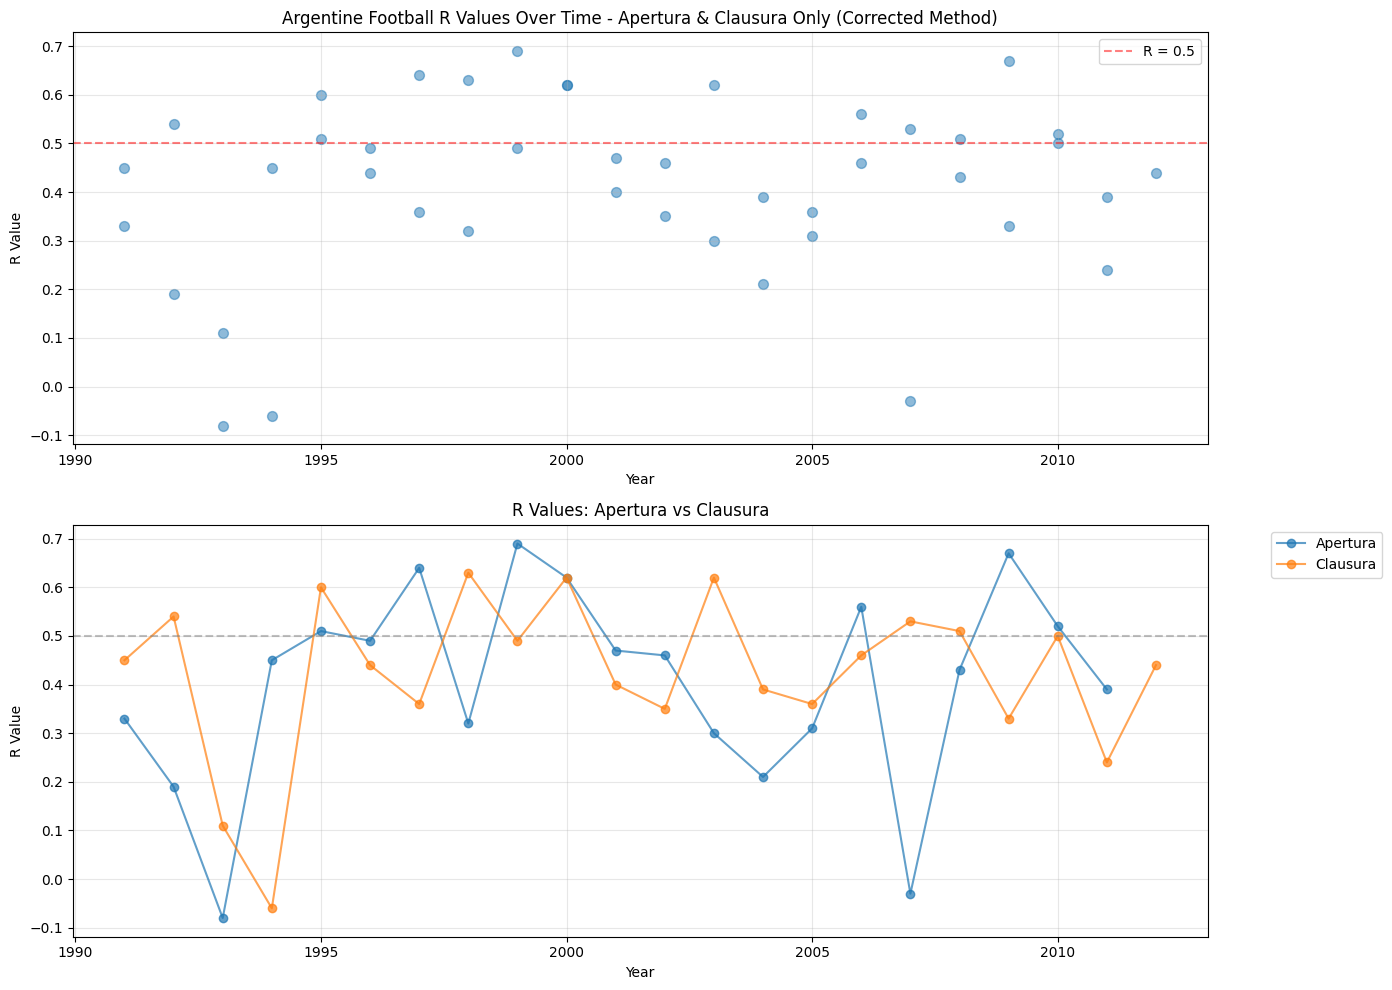

In [10]:
# R values over time with tournament types
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# All seasons
ax1.scatter(results_df['Year'], results_df['R_Value'], alpha=0.5, s=50)
ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='R = 0.5')
ax1.set_xlabel('Year')
ax1.set_ylabel('R Value')
ax1.set_title('Argentine Football R Values Over Time - Apertura & Clausura Only (Corrected Method)')
ax1.legend()
ax1.grid(alpha=0.3)

# By tournament type
for tournament_type in results_df['TournamentType'].unique():
    data = results_df[results_df['TournamentType'] == tournament_type]
    ax2.plot(data['Year'], data['R_Value'], 'o-', label=tournament_type, alpha=0.7)

ax2.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('Year')
ax2.set_ylabel('R Value')
ax2.set_title('R Values: Apertura vs Clausura')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

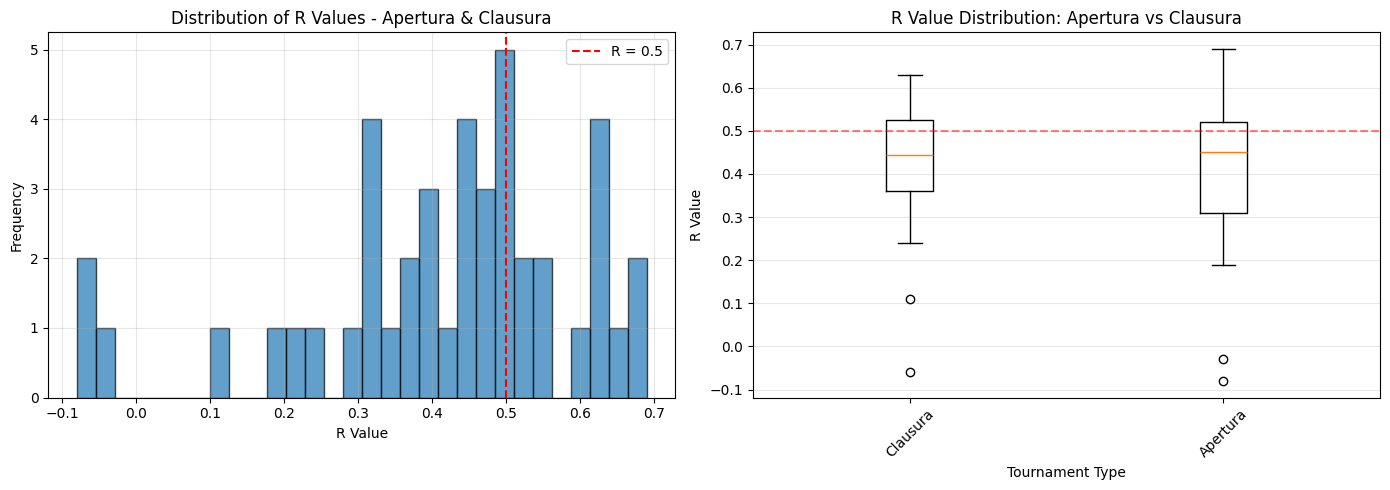

In [11]:
# Distribution of R values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1.hist(results_df['R_Value'].dropna(), bins=30, alpha=0.7, edgecolor='black')
ax1.axvline(x=0.5, color='red', linestyle='--', label='R = 0.5')
ax1.set_xlabel('R Value')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of R Values - Apertura & Clausura')
ax1.legend()
ax1.grid(alpha=0.3)

# Box plot by tournament type
tournament_types = summary.index.tolist()
data_for_box = [results_df[results_df['TournamentType'] == tt]['R_Value'].dropna() for tt in tournament_types]
ax2.boxplot(data_for_box, labels=tournament_types)
ax2.axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
ax2.set_xlabel('Tournament Type')
ax2.set_ylabel('R Value')
ax2.set_title('R Value Distribution: Apertura vs Clausura')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

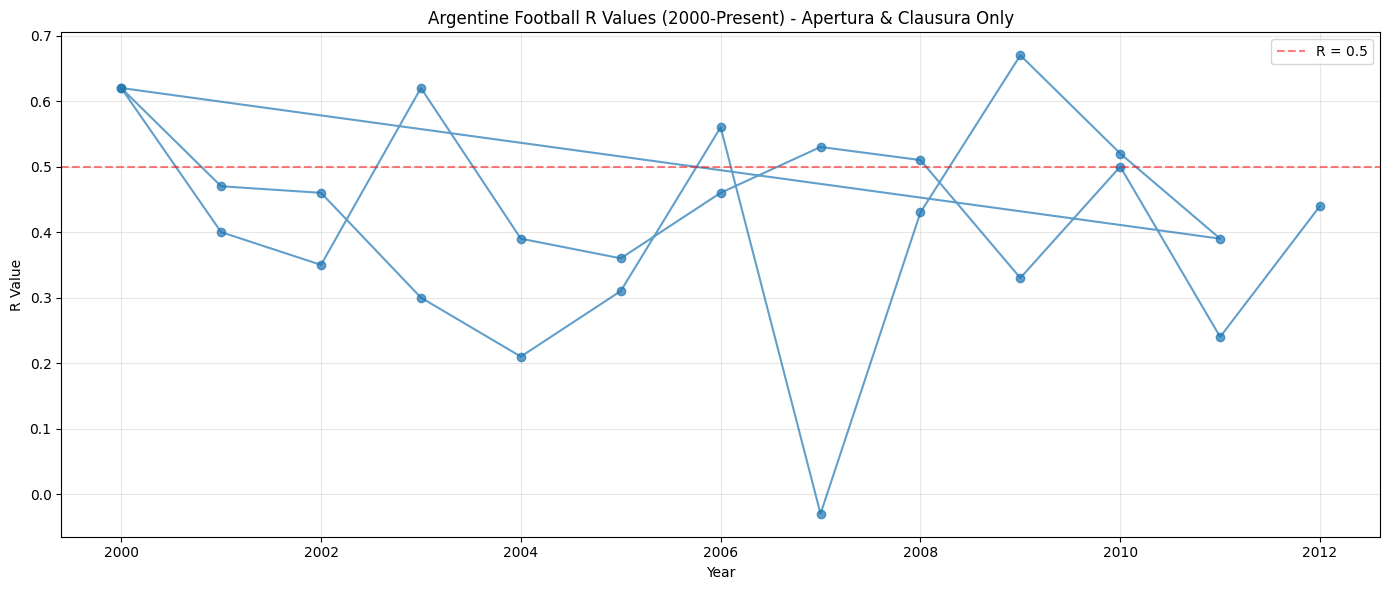


Recent Era (2000+) Summary - Apertura & Clausura:
Mean R: 0.426
Std R: 0.154


In [12]:
# Recent trends (last 20 years)
recent = results_df[results_df['Year'] >= 2000]

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(recent['Year'], recent['R_Value'], 'o-', alpha=0.7)
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='R = 0.5')
ax.set_xlabel('Year')
ax.set_ylabel('R Value')
ax.set_title('Argentine Football R Values (2000-Present) - Apertura & Clausura Only')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nRecent Era (2000+) Summary - Apertura & Clausura:")
print(f"Mean R: {recent['R_Value'].mean():.3f}")
print(f"Std R: {recent['R_Value'].std():.3f}")

## P vs Q Scatter Plot

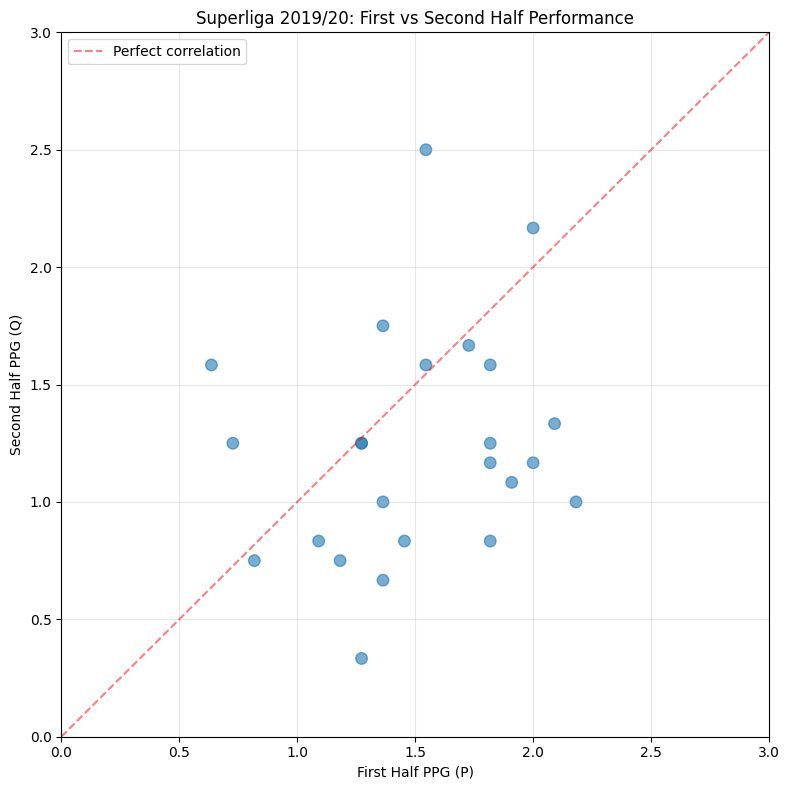


Correlation between first and second half: 0.206


In [13]:
# Example: Superliga 2019/20
example_season = 'Superliga 2019/20'
season_data = df[df['Season'] == example_season]
teams = sorted(set(season_data['HomeTeam']).union(set(season_data['AwayTeam'])))

P_values = []
Q_values = []
game_counts = []

for team in teams:
    team_games = get_team_games(season_data, team)
    n_games = len(team_games)

    if n_games < 4:
        continue

    # Split into first and second half
    half = n_games // 2
    first_half = team_games.iloc[:half]
    second_half = team_games.iloc[half:]

    p = first_half['points'].sum() / len(first_half)
    q = second_half['points'].sum() / len(second_half)

    P_values.append(p)
    Q_values.append(q)
    game_counts.append(n_games)

# Plot
if len(P_values) > 0:
    fig, ax = plt.subplots(figsize=(8, 8))
    sizes = [g * 3 for g in game_counts]
    ax.scatter(P_values, Q_values, s=sizes, alpha=0.6)
    ax.plot([0, 3], [0, 3], 'r--', alpha=0.5, label='Perfect correlation')
    ax.set_xlabel('First Half PPG (P)')
    ax.set_ylabel('Second Half PPG (Q)')
    ax.set_title(f'{example_season}: First vs Second Half Performance')
    ax.set_xlim(0, 3)
    ax.set_ylim(0, 3)
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\nCorrelation between first and second half: {np.corrcoef(P_values, Q_values)[0,1]:.3f}")

## Export Results

In [14]:

# Save detailed results
results_df.to_csv('argentina_r_values_corrected.csv', index=False)

# Save summary by tournament type
summary.to_csv('argentina_summary_by_tournament_corrected.csv')

print("Results exported!")
print(f"\nFiles created:")
print("- argentina_r_values_corrected.csv")
print("- argentina_summary_by_tournament_corrected.csv")

Results exported!

Files created:
- argentina_r_values_corrected.csv
- argentina_summary_by_tournament_corrected.csv
